In [1]:
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from random import randint, shuffle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import os

from keras.datasets import boston_housing

tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


# Related links

https://github.com/keras-team/keras/issues/7947 - comprehensive regression example

A target variable with a large spread of values, in turn, may result in large error gradient values causing weight values to change dramatically, making the learning process unstable. - https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

A good rule of thumb is that input variables should be small values, probably in the range of 0-1 (normalized with MinMaxScaler https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) or standardized (StandardScaler https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) with a zero mean and a standard deviation of one.

https://deepmind.com/blog/population-based-training-neural-networks/




In [2]:
def f(i, random_factor=10):
    return (i * (i + 1)) + randint(0,random_factor) # Added the random so we will get an error close to that

In [3]:
N = 500000 # Number of X points
Z = 10 # Number of Y per X point
M = Z * N # Number of Y to generate
data = []

for i in range(0,M): # Generate Y values
    calc = i % N # X position
    data.append([calc,f(calc)]) # Calculate Y
    
shuffle(data) # Better for training

In [4]:
len(data)

5000000

In [5]:
for i in range(0,5):
    print(data[i])

[127717, 16311759810]
[337203, 113706200416]
[472704, 223449544330]
[461934, 213383482294]
[131078, 17181573163]


In [6]:
df = pd.DataFrame(data, columns=['x','y'])

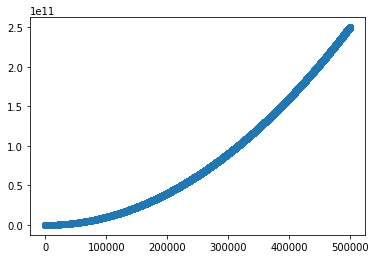

In [7]:
mpl.rcParams['agg.path.chunksize'] = 10000
#plt.yscale('log')
plt.plot(df['x'], df['y'], 'o')
plt.show()

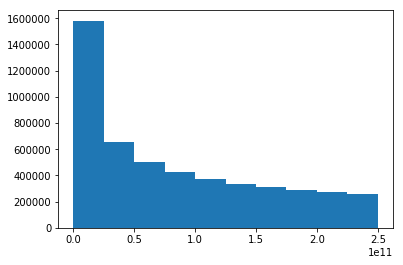

In [8]:
plt.hist(df['y'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9af81cd6d8>,
      dtype=object)

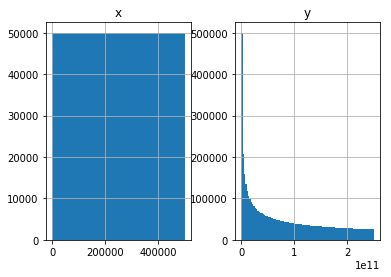

In [9]:
df.hist(bins=100)

In [10]:
for i in range(1000,1005):
    print(df.loc[df['x'] == i])

            x        y
1410184  1000  1001009
1497274  1000  1001006
2533043  1000  1001000
3495254  1000  1001005
3722211  1000  1001005
3815532  1000  1001004
4506002  1000  1001004
4565026  1000  1001001
4663391  1000  1001001
4852165  1000  1001010
            x        y
823399   1001  1003005
1125961  1001  1003003
1501541  1001  1003002
1679858  1001  1003011
1806875  1001  1003003
2064280  1001  1003002
2416685  1001  1003002
3851205  1001  1003005
3990125  1001  1003010
4004999  1001  1003007
            x        y
479853   1002  1005014
970828   1002  1005007
1072237  1002  1005016
2198834  1002  1005013
2875021  1002  1005011
3044015  1002  1005010
3134234  1002  1005016
3900237  1002  1005015
4262044  1002  1005011
4678724  1002  1005009
            x        y
332672   1003  1007016
387037   1003  1007022
2241766  1003  1007013
2807511  1003  1007019
2882727  1003  1007015
3673789  1003  1007022
4116699  1003  1007014
4200025  1003  1007016
4768016  1003  1007019
4928749  10

In [11]:
def seq_model(lr=0.001, hidden_layers=3, hidden_layers_size=100, batch_normalization=False):
    
    print('hl={} hls={} lr={}'.format(hidden_layers, hidden_layers_size, lr))
    
    x_input = Input(shape=(1,)) # X
    
    input_layer = Dense(hidden_layers_size, activation='relu', input_shape=(1,))
    
    model = Sequential()
    
    if batch_normalization:
        model.add(BatchNormalization())
    
    model.add(input_layer)
    
    for i in range(0, hidden_layers):
        hl = Dense(hidden_layers_size, activation='relu')
        model.add(hl)
    
    output_layer = Dense(1)
        
    model.add(output_layer)
    
    adam = Adam(lr=lr)
    model.compile(optimizer=adam, loss='mse', metrics=["mean_squared_error"]) # accuracy is only for classification: metrics=['accuracy'])
    
    model.summary()
    
    return model

In [12]:
df['y'].mean()

83333333338.00203

In [13]:
df['y'].max()

249999500010

In [14]:
df_min = df.min()
df_max = df.max()
y_min = df['y'].min()
y_max = df['y'].max()
df = (df - df_min) / (df_max - df_min) # MinMax normalization

In [15]:
def from_min_max(y):
    print(type(y))
    return y * (y_max - y_min) + y_min

In [16]:
df['y'].mean()

0.3333340000066749

In [17]:
df['y'].max()

1.0

In [18]:
df.round(2).describe()

,x,y
count,5.000000e+06,5.000000e+06
mean,5.000000e-01,3.332752e-01
std,2.887040e-01,2.982292e-01
min,0.000000e+00,0.000000e+00
25%,2.500000e-01,6.000000e-02
50%,5.000000e-01,2.500000e-01
75%,7.500000e-01,5.600000e-01
max,1.000000e+00,1.000000e+00


In [19]:
def fit_model(model, data, patience=3,verbose=1,epochs=5):
    if patience:
        early = EarlyStopping(monitor="loss", patience=patience, mode='auto')
        return model.fit(
            data['x'], 
            data['y'], 
            validation_split=0.3,
            epochs=epochs,
            batch_size=256,
            verbose=verbose,
            callbacks = [early]
        ) # Fit our weigths to the data
    
    return model.fit(
            data['x'], 
            data['y'], 
            validation_split=0.3,
            epochs=epochs,
            batch_size=256,
            verbose=verbose
        ) # Fit our weigths to the data

In [20]:
def plot_history(history, classification=False):
    # list all data in history
    print(history.history.keys())
    if classification:
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

---------------
---------------
---------------
Loading ./1-100-0.0001.h5
Fitting 0.0001...
Loading ./1-100-0.0001-history
Saving model and history
Plotting fit score...
dict_keys(['mean_squared_error', 'loss', 'val_loss', 'val_mean_squared_error'])


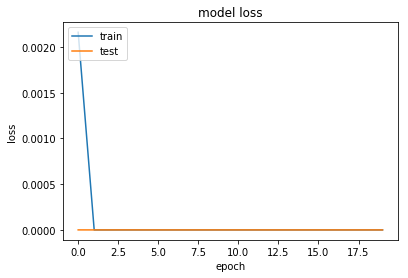

Predict...
[[-0.00020238]]
---------------
---------------
---------------
Loading ./1-100-1e-05.h5
Fitting 1e-05...
Loading ./1-100-1e-05-history
Saving model and history
Plotting fit score...
dict_keys(['mean_squared_error', 'loss', 'val_loss', 'val_mean_squared_error'])


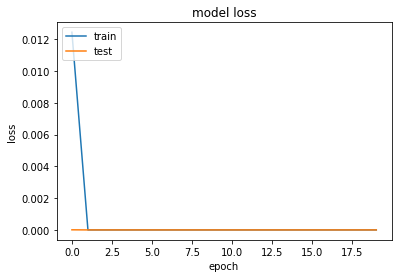

Predict...
[[-0.00010169]]
---------------
---------------
---------------
Loading ./1-100-1e-06.h5
Fitting 1e-06...
Loading ./1-100-1e-06-history
Saving model and history
Plotting fit score...
dict_keys(['mean_squared_error', 'loss', 'val_loss', 'val_mean_squared_error'])


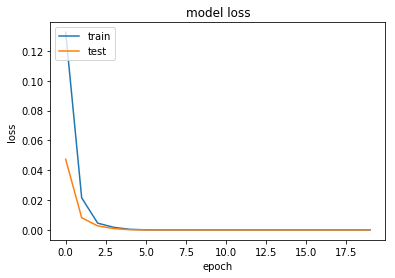

Predict...
[[-0.00056171]]
---------------
---------------
---------------
Loading ./1-1000-0.0001.h5
Fitting 0.0001...
Loading ./1-1000-0.0001-history
Saving model and history
Plotting fit score...
dict_keys(['mean_squared_error', 'loss', 'val_loss', 'val_mean_squared_error'])


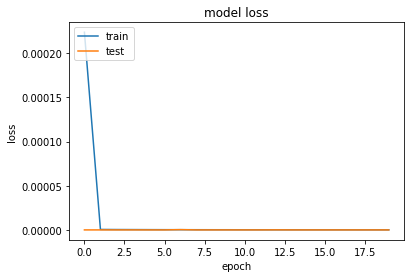

Predict...
[[-1.4400485e-05]]
---------------
---------------
---------------
Loading ./1-1000-1e-05.h5
Fitting 1e-05...
Loading ./1-1000-1e-05-history
Saving model and history
Plotting fit score...
dict_keys(['mean_squared_error', 'loss', 'val_loss', 'val_mean_squared_error'])


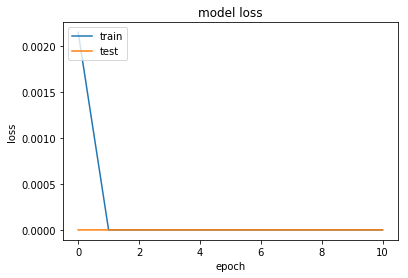

Predict...
[[-6.8872934e-05]]
---------------
---------------
---------------
Loading ./1-1000-1e-06.h5
Fitting 1e-06...
Loading ./1-1000-1e-06-history
Saving model and history
Plotting fit score...
dict_keys(['mean_squared_error', 'loss', 'val_loss', 'val_mean_squared_error'])


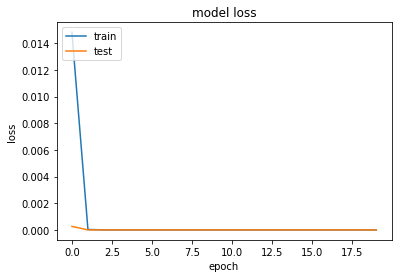

Predict...
[[-0.00020549]]
---------------
---------------
---------------
Loading ./2-100-0.0001.h5
Fitting 0.0001...
Loading ./2-100-0.0001-history
Saving model and history
Plotting fit score...
dict_keys(['mean_squared_error', 'loss', 'val_loss', 'val_mean_squared_error'])


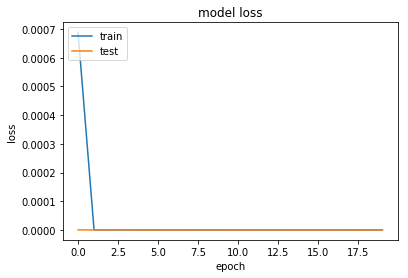

Predict...
[[-8.6641405e-05]]
---------------
---------------
---------------
Loading ./2-100-1e-05.h5
Fitting 1e-05...
Loading ./2-100-1e-05-history
Saving model and history
Plotting fit score...
dict_keys(['mean_squared_error', 'loss', 'val_loss', 'val_mean_squared_error'])


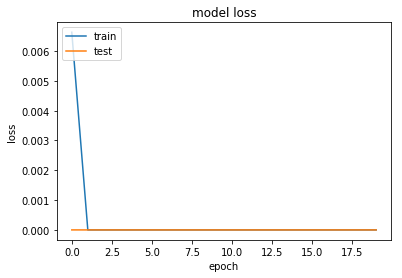

Predict...
[[-5.315733e-05]]
---------------
---------------
---------------
Loading ./2-100-1e-06.h5
Fitting 1e-06...
Loading ./2-100-1e-06-history
Saving model and history
Plotting fit score...
dict_keys(['mean_squared_error', 'loss', 'val_loss', 'val_mean_squared_error'])


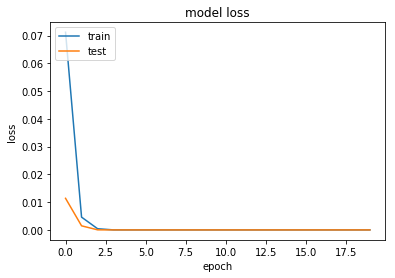

Predict...
[[-0.0003184]]
---------------
---------------
---------------
Loading ./2-1000-0.0001.h5
Fitting 0.0001...
Loading ./2-1000-0.0001-history
Saving model and history
Plotting fit score...
dict_keys(['mean_squared_error', 'loss', 'val_loss', 'val_mean_squared_error'])


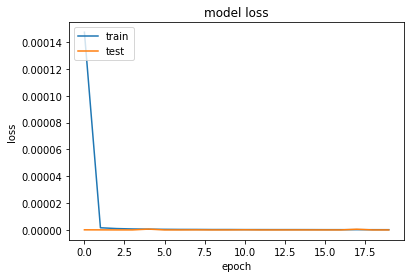

Predict...
[[1.9487925e-06]]
---------------
---------------
---------------
Loading ./2-1000-1e-05.h5
Fitting 1e-05...
Loading ./2-1000-1e-05-history


EOFError: Ran out of input

In [22]:
histories = {}

def g_load_history(hl,hls,lr):
    f_name = './{}-{}-{}-history'.format(hl,hls,lr)
    if os.path.exists(f_name):
        with open(f_name, 'rb') as f:
            print("Loading {}".format(f_name))
            return pickle.load(f)
    else:
        print("Couldnt find {}".format(f_name))
        return None
    
def g_load_model(hl,hls,lr):
    f_name = './{}-{}-{}.h5'.format(hl,hls,lr)
    if os.path.exists(f_name):
        print("Loading {}".format(f_name))
        return load_model(f_name)
    else:
        print("Couldnt find {}".format(f_name))
        return None

def generate_models(hl_in=[1,2,3], hls_in=[100,1000], lr_in=[0.0001, 0.00001, 0.000001], epochs=20):
    for hl in hl_in: #, 3]: # Try different number of hidden layers

        hl_h = histories.get(hl, {})

        for hls in hls_in:

            hls_h = hl_h.get(hls, {})

            for i in lr_in: #[0.001, 0.0001, 0.00001]: # Try different learning rates

                print('---------------')
                print('---------------')
                print('---------------')

                model = g_load_model(hl,hls,i)
                
                if model == None:
                    model = seq_model(lr=i, hidden_layers=hl, hidden_layers_size=hls)
                    print('Saving model and history')
                    model.save('{}-{}-{}.h5'.format(hl,hls,i))

                print('Fitting {}...'.format(i))
                
                history = g_load_history(hl,hls,i)
                
                if history == None:
                    history = fit_model(model, df, patience=3, verbose=1, epochs=epochs)
                
                    with open('{}-{}-{}-history'.format(hl,hls,i), 'wb') as f:
                        pickle.dump(history, f)

                #print('Evaluate...')
                #scores = model.evaluate(df['x'], df['y'])
                # Accuracy is only for classification
                # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

                print('Plotting fit score...')
                plot_history(history)

                print('Predict...')
                print(model.predict([0.00005]))

                hls_h[i] =  {'hls': hls, 'hls_h': hls_h, 'lr': i, 'model': model, 'history': history}

            hl_h[hls] = hls_h

        histories[hl] = hl_h
    
generate_models()

In [ ]:
df.loc[df['x'].round(6) == 0.00005]

In [ ]:
def plot_histories(prop):
    legend=[]

    plt.figure(figsize=(20, 6))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.yscale('log')

    for hl in histories.keys():
        for hls in histories[hl].keys():
            for lr in histories[hl][hls].keys():
                print('hl={} hls={} lr={} min_loss={} min_val_loss={}'.format(
                    hl, 
                    hls, 
                    lr,
                    min(histories[hl][hls][lr]['history'].history[prop]) * (y_max - y_min) + y_min,
                ))
                plt.plot(histories[hl][hls][lr]['history'].history[prop])
                legend = legend + [ 'train-{}-{}-{}'.format(hl,hls,lr), 'test-{}-{}-{}'.format(hl,hls,lr) ]

    plt.legend(legend, loc='best', ncol=5)
    plt.show()
    
plot_histories('loss')
plot_histories('val_loss')

In [ ]:
# Generate new data to test

new_data = []

for i in range(0,N):
    new_data.append([i,f(i,random_factor=100)])
    
new_df = pd.DataFrame(new_data, columns=['x','y'])
new_y_min = new_df.min()
new_y_max = new_df.max()
new_df = (new_df - new_y_min) / (new_y_max - new_y_min) # MinMax normalization

x = new_df['x']
y = new_df['y']

In [ ]:
legend=[]

plt.figure(figsize=(20, 6))
plt.plot(x, y, 'o')
legend = legend + [ 'original data' ]
plt.title('Predictions')
#plt.yscale('log')

for hl in histories.keys():
    for hls in histories[hl].keys():
        for lr in histories[hl][hls].keys():
            plt.plot(x, histories[hl][hls][lr]['model'].predict(x))
            legend = legend + [ '{}-{}-{}'.format(hl,hls,lr) ]
            #print("Done")
            

plt.legend(legend, loc='best', ncol=5)
plt.show()